In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the different packages
import pandas as pd
import numpy as np
import functools as ft
from matplotlib import mlab
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_theme(style="white", palette='Greens_r', font='serif')

In [ ]:
# load the data using feather which is faster
data = pd.read_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/transactions.feather")

In [ ]:
data.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,price,inv_is_order,return,day,weekend,month,quarter,year,cohort
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732,51.81440,1,0,0,0,9,3,2017,20173
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279,5.46480,1,0,0,0,9,3,2017,20173
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184,17.41744,1,0,0,0,9,3,2017,20173
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200,0.04278,1,0,0,0,9,3,2017,20173
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051,364.45800,1,0,0,0,9,3,2017,20173


In [ ]:
# we only need these specific features
data = data.loc[:,["date_order", "client_id", "sales_net", "order_channel", "price"]]

In [ ]:
data.dtypes

date_order       datetime64[ns]
client_id                uint32
sales_net               float64
order_channel          category
price                   float64
dtype: object

In [ ]:
# we create a new variable price category by cutting the data in three different quantiles based on price
# data['price_cat'] = pd.qcut(x=data['price'], q = 3, labels=[1,2,3])
data["price_cat"] = pd.cut(x=data['price'], bins = [0, 50, 1000, 500000], labels=[1,2,3])

In [ ]:
data.head()

,date_order,client_id,sales_net,order_channel,price,price_cat
0,2017-09-25,188502,155.44320,online,51.81440,2
1,2017-09-25,835089,16.39440,at the store,5.46480,1
2,2017-09-25,1977896,365.76624,online,17.41744,1
3,2017-09-25,598816,8.59878,at the store,0.04278,1
4,2017-09-25,2086861,1093.37400,by phone,364.45800,2


In [ ]:
data.drop(columns = 'price', inplace = True)

In [ ]:
# time as a customer: last order minus first order
data['diff'] = data.groupby('client_id')['date_order'].transform(lambda x: (x.max()-x.min()).days)

In [ ]:
# We check the amount of zeros for diff because they won't make any sense to calculate the CLV
# that's the reason why we make in the next cell a calculation to delete the rows with zeros and NaNs
len(data[data['diff'] == 0])

88835

In [ ]:
# we only keep the data different to zero
data = data[data["diff"] != 0]

In [ ]:
# profit margins per product category
data.loc[data["price_cat"] == 1,"profit_margin"] = 0.10
data.loc[data["price_cat"] == 2,"profit_margin"] = 0.16
data.loc[data["price_cat"] == 3,"profit_margin"] = 0.22
data.head()

,date_order,client_id,sales_net,order_channel,price_cat,diff,profit_margin
0,2017-09-25,188502,155.44320,online,2,710,0.16
1,2017-09-25,835089,16.39440,at the store,1,725,0.10
2,2017-09-25,1977896,365.76624,online,1,406,0.10
3,2017-09-25,598816,8.59878,at the store,1,714,0.10
4,2017-09-25,2086861,1093.37400,by phone,2,717,0.16


In [ ]:
#
##
###
# Here we start building the three different models based on the different assumptions of profit margin and acquisition cost
###
##
#

In [ ]:
#
##
###
# Model 1: Basic Model
###
##
#

In [ ]:
df = data.copy()

In [ ]:
df.drop(columns = 'date_order', inplace = True)
df.head()

,client_id,sales_net,order_channel,price_cat,diff,profit_margin
0,188502,155.44320,online,2,710,0.16
1,835089,16.39440,at the store,1,725,0.10
2,1977896,365.76624,online,1,406,0.10
3,598816,8.59878,at the store,1,714,0.10
4,2086861,1093.37400,by phone,2,717,0.16


In [ ]:
# then caclulate the annual sales, e.g., amount / 90 d * 365 d
df["Average_annual_sales"] = (df["sales_net"]/df["diff"])  * 365
df.head()

,client_id,sales_net,order_channel,price_cat,diff,profit_margin,Average_annual_sales
0,188502,155.44320,online,2,710,0.16,79.910941
1,835089,16.39440,at the store,1,725,0.10,8.253732
2,1977896,365.76624,online,1,406,0.10,328.829255
3,598816,8.59878,at the store,1,714,0.10,4.395735
4,2086861,1093.37400,by phone,2,717,0.16,556.599038


In [ ]:
# calculate already the average_annual_sales by retention_rate
df["Sales_Margin"] = df["Average_annual_sales"] * df["profit_margin"]
df.head()

,client_id,sales_net,order_channel,price_cat,diff,profit_margin,Average_annual_sales,Sales_Margin
0,188502,155.44320,online,2,710,0.16,79.910941,12.785751
1,835089,16.39440,at the store,1,725,0.10,8.253732,0.825373
2,1977896,365.76624,online,1,406,0.10,328.829255,32.882926
3,598816,8.59878,at the store,1,714,0.10,4.395735,0.439573
4,2086861,1093.37400,by phone,2,717,0.16,556.599038,89.055846


In [ ]:
#check for nan values - which occur if a person only buys once
df.isna().mean()

client_id               0.000000
sales_net               0.000000
order_channel           0.000000
price_cat               0.075796
diff                    0.000000
profit_margin           0.075796
Average_annual_sales    0.000000
Sales_Margin            0.075796
dtype: float64

In [ ]:
# per client_id we want to know the most frequent order_channel because they will give us different retention rates
df1 = df.groupby("client_id")["order_channel"].agg(lambda x: x.mode())
df1.head()

client_id
6         by phone
7     at the store
14        by phone
18    at the store
37    at the store
Name: order_channel, dtype: object

In [ ]:
df2 = pd.merge(df, df1, how="left", left_on=["client_id"], right_on=["client_id"])
df2.head()

,client_id,sales_net,order_channel_x,price_cat,diff,profit_margin,Average_annual_sales,Sales_Margin,order_channel_y
0,188502,155.44320,online,2,710,0.16,79.910941,12.785751,online
1,835089,16.39440,at the store,1,725,0.10,8.253732,0.825373,at the store
2,1977896,365.76624,online,1,406,0.10,328.829255,32.882926,online
3,598816,8.59878,at the store,1,714,0.10,4.395735,0.439573,at the store
4,2086861,1093.37400,by phone,2,717,0.16,556.599038,89.055846,at the store


In [ ]:
df2.drop(columns = "order_channel_x", inplace = True)
df2.rename(columns = {'order_channel_y':'order_channel'}, inplace = True)
df2.head()

,client_id,sales_net,price_cat,diff,profit_margin,Average_annual_sales,Sales_Margin,order_channel
0,188502,155.44320,2,710,0.16,79.910941,12.785751,online
1,835089,16.39440,1,725,0.10,8.253732,0.825373,at the store
2,1977896,365.76624,1,406,0.10,328.829255,32.882926,online
3,598816,8.59878,1,714,0.10,4.395735,0.439573,at the store
4,2086861,1093.37400,2,717,0.16,556.599038,89.055846,at the store


In [ ]:
df2.head()

,client_id,sales_net,price_cat,diff,profit_margin,Average_annual_sales,Sales_Margin,order_channel
0,188502,155.44320,2,710,0.16,79.910941,12.785751,online
1,835089,16.39440,1,725,0.10,8.253732,0.825373,at the store
2,1977896,365.76624,1,406,0.10,328.829255,32.882926,online
3,598816,8.59878,1,714,0.10,4.395735,0.439573,at the store
4,2086861,1093.37400,2,717,0.16,556.599038,89.055846,at the store


In [ ]:
df2.dtypes

client_id                 uint32
sales_net                float64
price_cat               category
diff                       int64
profit_margin            float64
Average_annual_sales     float64
Sales_Margin             float64
order_channel             object
dtype: object

In [ ]:
df2["best_channel"] = df2["order_channel"].astype("string").astype("category")

In [ ]:
df2.drop(columns = "order_channel", inplace = True)

In [ ]:
# lifetime based on average retention rate (see Retention Curves notebook)
df2.loc[df2["best_channel"] == "at the store", "retention_rate"] = 0.443
df2.loc[df2["best_channel"] == "by phone", "retention_rate"] = 0.41
df2.loc[df2["best_channel"] == "other", "retention_rate"] = 0.284
df2.loc[df2["best_channel"] == "online", "retention_rate"] = 0.641
df2.loc[df2["best_channel"] == "during the visit of a sales rep", "retention_rate"] = 0.49
df2.head()

,client_id,sales_net,price_cat,diff,profit_margin,Average_annual_sales,Sales_Margin,best_channel,retention_rate
0,188502,155.44320,2,710,0.16,79.910941,12.785751,online,0.641
1,835089,16.39440,1,725,0.10,8.253732,0.825373,at the store,0.443
2,1977896,365.76624,1,406,0.10,328.829255,32.882926,online,0.641
3,598816,8.59878,1,714,0.10,4.395735,0.439573,at the store,0.443
4,2086861,1093.37400,2,717,0.16,556.599038,89.055846,at the store,0.443


In [ ]:
df2["lifetime"] = 1 / (1-df2.loc[:,"retention_rate"])
df2.head()

,client_id,sales_net,price_cat,diff,profit_margin,Average_annual_sales,Sales_Margin,best_channel,retention_rate,lifetime
0,188502,155.44320,2,710,0.16,79.910941,12.785751,online,0.641,2.785515
1,835089,16.39440,1,725,0.10,8.253732,0.825373,at the store,0.443,1.795332
2,1977896,365.76624,1,406,0.10,328.829255,32.882926,online,0.641,2.785515
3,598816,8.59878,1,714,0.10,4.395735,0.439573,at the store,0.443,1.795332
4,2086861,1093.37400,2,717,0.16,556.599038,89.055846,at the store,0.443,1.795332


In [ ]:
clv = df2.loc[:,["client_id", "Sales_Margin",  "lifetime"]]
clv.head()

,client_id,Sales_Margin,lifetime
0,188502,12.785751,2.785515
1,835089,0.825373,1.795332
2,1977896,32.882926,2.785515
3,598816,0.439573,1.795332
4,2086861,89.055846,1.795332


In [ ]:
# applying the formula to calculate clv
discount_factor = 0.05
acquisition_cost = 2
clv["clv"] = ((clv["Sales_Margin"] * clv["lifetime"]) / (1 + discount_factor )**clv["lifetime"])-acquisition_cost
clv.head()

,client_id,Sales_Margin,lifetime,clv
0,188502,12.785751,2.785515,29.089137
1,835089,0.825373,1.795332,-0.642458
2,1977896,32.882926,2.785515,77.956336
3,598816,0.439573,1.795332,-1.277006
4,2086861,89.055846,1.795332,144.475642


In [ ]:
# aggregate to sum of clvs per client_id to get the total clv per client
final_clv = clv.groupby("client_id").agg(total_clv = ("clv", "sum"))

In [ ]:
final_clv.head()

,total_clv
client_id,
6,479.103284
7,414.017852
14,304749.686434
18,24149.477495
37,914.626424


In [ ]:
final_clv = final_clv.reset_index()

In [ ]:
final_clv.to_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/final_clv_basic.feather")

In [ ]:
#
##
###
####
# Up until now we had the basic model, now we want to improve it => Model 2
# This model will have adapted profit margins depending on the client's size and order_channel
# Apart from changing the profit margins, we use the same steps as before
####
###
##
#

In [ ]:
df_advanced = data.copy()

In [ ]:
df_advanced.head()

,date_order,client_id,sales_net,order_channel,price_cat,diff,profit_margin
0,2017-09-25,188502,155.44320,online,2,710,0.16
1,2017-09-25,835089,16.39440,at the store,1,725,0.10
2,2017-09-25,1977896,365.76624,online,1,406,0.10
3,2017-09-25,598816,8.59878,at the store,1,714,0.10
4,2017-09-25,2086861,1093.37400,by phone,2,717,0.16


In [ ]:
df_advanced = df_advanced.loc[:,["client_id", "sales_net", "order_channel", "price_cat", "diff", "profit_margin"]]
df_advanced.head()

,client_id,sales_net,order_channel,price_cat,diff,profit_margin
0,188502,155.44320,online,2,710,0.16
1,835089,16.39440,at the store,1,725,0.10
2,1977896,365.76624,online,1,406,0.10
3,598816,8.59878,at the store,1,714,0.10
4,2086861,1093.37400,by phone,2,717,0.16


In [ ]:
df_advanced.loc[df_advanced["order_channel"] == "at the store", "order_channel_margin"] = 1
df_advanced.loc[df_advanced["order_channel"] == "by phone", "order_channel_margin"] = 1.2
df_advanced.loc[df_advanced["order_channel"] == "other", "order_channel_margin"] = 0.8
df_advanced.loc[df_advanced["order_channel"] == "online", "order_channel_margin"] = 1.3
df_advanced.loc[df_advanced["order_channel"] == "during the visit of a sales rep", "order_channel_margin"] = 0.9
df_advanced.head()

,client_id,sales_net,order_channel,price_cat,diff,profit_margin,order_channel_margin
0,188502,155.44320,online,2,710,0.16,1.3
1,835089,16.39440,at the store,1,725,0.10,1.0
2,1977896,365.76624,online,1,406,0.10,1.3
3,598816,8.59878,at the store,1,714,0.10,1.0
4,2086861,1093.37400,by phone,2,717,0.16,1.2


In [ ]:
df1_advanced = df_advanced.groupby("client_id").agg(sales = ("sales_net", "sum"))

In [ ]:
df1_advanced.describe()

,sales
count,1.495080e+05
mean,6.249048e+04
std,2.595197e+05
min,-9.239541e+02
25%,2.249083e+03
50%,8.709396e+03
75%,3.672409e+04
max,2.755879e+07


In [ ]:
df1_advanced["client_size"] = pd.cut(x=df1_advanced['sales'], bins = [-1000,8710,70000,3e7], labels=["small","medium","big"])
df1_advanced.head()

,sales,client_size
client_id,,
6,5.882233e+03,small
7,1.190777e+03,small
14,3.103187e+06,big
18,2.194882e+05,big
37,6.591136e+03,small


In [ ]:
df1_advanced["client_size"].value_counts()

small     74756
medium    50252
big       24500
Name: client_size, dtype: int64

In [ ]:
df1_advanced.loc[df1_advanced["client_size"] == "small", "client_size_margin"] = 1.2
df1_advanced.loc[df1_advanced["client_size"] == "medium", "client_size_margin"] = 1
df1_advanced.loc[df1_advanced["client_size"] == "big", "client_size_margin"] = 0.8
df1_advanced.head()

,sales,client_size,client_size_margin
client_id,,,
6,5.882233e+03,small,1.2
7,1.190777e+03,small,1.2
14,3.103187e+06,big,0.8
18,2.194882e+05,big,0.8
37,6.591136e+03,small,1.2


In [ ]:
df2_advanced = pd.merge(df_advanced, df1_advanced, how="left", left_on=["client_id"], right_on=["client_id"])
df2_advanced.head()

,client_id,sales_net,order_channel,price_cat,diff,profit_margin,order_channel_margin,sales,client_size,client_size_margin
0,188502,155.44320,online,2,710,0.16,1.3,66700.338550,medium,1.0
1,835089,16.39440,at the store,1,725,0.10,1.0,291603.649551,big,0.8
2,1977896,365.76624,online,1,406,0.10,1.3,145390.906671,big,0.8
3,598816,8.59878,at the store,1,714,0.10,1.0,222614.512609,big,0.8
4,2086861,1093.37400,by phone,2,717,0.16,1.2,40332.010169,medium,1.0


In [ ]:
df2_advanced["final_margin"] = df2_advanced["profit_margin"] * df2_advanced["order_channel_margin"] * df2_advanced["client_size_margin"]
df2_advanced.head()

,client_id,sales_net,order_channel,price_cat,diff,profit_margin,order_channel_margin,sales,client_size,client_size_margin,final_margin
0,188502,155.44320,online,2,710,0.16,1.3,66700.338550,medium,1.0,0.208
1,835089,16.39440,at the store,1,725,0.10,1.0,291603.649551,big,0.8,0.080
2,1977896,365.76624,online,1,406,0.10,1.3,145390.906671,big,0.8,0.104
3,598816,8.59878,at the store,1,714,0.10,1.0,222614.512609,big,0.8,0.080
4,2086861,1093.37400,by phone,2,717,0.16,1.2,40332.010169,medium,1.0,0.192


In [ ]:
df2_advanced["Average_annual_sales"] = (df2_advanced["sales_net"]/df2_advanced["diff"]) * 365

In [ ]:
df2_advanced["Sales_Margin"] = df2_advanced["Average_annual_sales"] * df2_advanced["final_margin"]

In [ ]:
df2_advanced.head()

,client_id,sales_net,order_channel,price_cat,diff,profit_margin,order_channel_margin,sales,client_size,client_size_margin,final_margin,Average_annual_sales,Sales_Margin
0,188502,155.44320,online,2,710,0.16,1.3,66700.338550,medium,1.0,0.208,79.910941,16.621476
1,835089,16.39440,at the store,1,725,0.10,1.0,291603.649551,big,0.8,0.080,8.253732,0.660299
2,1977896,365.76624,online,1,406,0.10,1.3,145390.906671,big,0.8,0.104,328.829255,34.198243
3,598816,8.59878,at the store,1,714,0.10,1.0,222614.512609,big,0.8,0.080,4.395735,0.351659
4,2086861,1093.37400,by phone,2,717,0.16,1.2,40332.010169,medium,1.0,0.192,556.599038,106.867015


In [ ]:
df2_advanced.loc[df2_advanced["order_channel"] == "at the store", "retention_rate"] = 0.443
df2_advanced.loc[df2_advanced["order_channel"] == "by phone", "retention_rate"] = 0.41
df2_advanced.loc[df2_advanced["order_channel"] == "other", "retention_rate"] = 0.284
df2_advanced.loc[df2_advanced["order_channel"] == "online", "retention_rate"] = 0.641
df2_advanced.loc[df2_advanced["order_channel"] == "during the visit of a sales rep", "retention_rate"] = 0.49

In [ ]:
clv_advanced = df2_advanced.loc[:,["client_id", "Sales_Margin", "retention_rate"]]
clv_advanced.head()

,client_id,Sales_Margin,retention_rate
0,188502,16.621476,0.641
1,835089,0.660299,0.443
2,1977896,34.198243,0.641
3,598816,0.351659,0.443
4,2086861,106.867015,0.410


In [ ]:
clv_advanced["lifetime"] = 1 / (1-clv_advanced.loc[:,"retention_rate"])

In [ ]:
clv_advanced = clv_advanced.loc[:,["client_id", "Sales_Margin",  "lifetime"]]

In [ ]:
discount_factor = 0.05
acquisition_cost = 2
clv_advanced["clv"] = ((clv_advanced["Sales_Margin"] * clv_advanced["lifetime"]) / (1 + discount_factor )**clv_advanced["lifetime"])-acquisition_cost
clv_advanced.head()

,client_id,Sales_Margin,lifetime,clv
0,188502,16.621476,2.785515,38.415878
1,835089,0.660299,1.795332,-0.913966
2,1977896,34.198243,2.785515,81.154589
3,598816,0.351659,1.795332,-1.421605
4,2086861,106.867015,1.694915,164.754515


In [ ]:
final_clv_advanced = clv_advanced.groupby("client_id").agg(total_clv = ("clv", "sum"))
final_clv_advanced.head()

,total_clv
client_id,
6,699.743369
7,502.821423
14,322660.946403
18,21712.601810
37,1241.297224


In [ ]:
final_clv_advanced = final_clv_advanced.reset_index()

In [ ]:
final_clv_advanced.to_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/final_clv_advanced.feather")

In [ ]:
#
##
###
####
# Up until now we had a basic and advanced model, now we want to improve to advanced mdoel by creating an adapted acquisition cost => Model 3
# This adapted acquisition cost is based on the channel the clients used for their first purchase
####
###
##
#

In [ ]:
df_improved = data.copy()
df_improved.head()

,date_order,client_id,sales_net,order_channel,price_cat,diff,profit_margin
0,2017-09-25,188502,155.44320,online,2,710,0.16
1,2017-09-25,835089,16.39440,at the store,1,725,0.10
2,2017-09-25,1977896,365.76624,online,1,406,0.10
3,2017-09-25,598816,8.59878,at the store,1,714,0.10
4,2017-09-25,2086861,1093.37400,by phone,2,717,0.16


In [ ]:
df_improved = df_improved.loc[:,["date_order", "client_id", "sales_net", "order_channel"]]
df_improved.head()

,date_order,client_id,sales_net,order_channel
0,2017-09-25,188502,155.44320,online
1,2017-09-25,835089,16.39440,at the store
2,2017-09-25,1977896,365.76624,online
3,2017-09-25,598816,8.59878,at the store
4,2017-09-25,2086861,1093.37400,by phone


In [ ]:
first_contact = df_improved.groupby("client_id").agg(first_contact = ("order_channel", "first"))
first_contact.head()

,first_contact
client_id,
6,by phone
7,at the store
14,by phone
18,at the store
37,at the store


In [ ]:
df1_improved = pd.merge(df_improved, first_contact, how="left", left_on=["client_id"], right_on=["client_id"])
df1_improved.head()

,date_order,client_id,sales_net,order_channel,first_contact
0,2017-09-25,188502,155.44320,online,online
1,2017-09-25,835089,16.39440,at the store,at the store
2,2017-09-25,1977896,365.76624,online,online
3,2017-09-25,598816,8.59878,at the store,at the store
4,2017-09-25,2086861,1093.37400,by phone,by phone


In [ ]:
# to check if there are differences between order_channel and first_contact since the dataset is time based
df1_improved.tail(40)

,date_order,client_id,sales_net,order_channel,first_contact
63230440,2019-04-30,1189723,-504.804000,by phone,at the store
63230441,2019-09-05,955108,-124.696800,by phone,by phone
63230442,2019-09-02,1314676,-18.850800,at the store,at the store
63230443,2019-08-14,1150574,3.201600,online,at the store
63230444,2019-08-02,280638,-735.512400,by phone,at the store
63230445,2019-07-17,1354446,-5.961600,online,online
63230446,2019-06-13,2272758,1942.580000,by phone,online
63230447,2018-06-28,1606180,2760.000000,by phone,by phone
63230448,2019-09-20,670779,-6434.480000,by phone,by phone
63230449,2019-06-21,844620,-6.210000,by phone,by phone


In [ ]:
df1_improved.head()

,date_order,client_id,sales_net,order_channel,first_contact
0,2017-09-25,188502,155.44320,online,online
1,2017-09-25,835089,16.39440,at the store,at the store
2,2017-09-25,1977896,365.76624,online,online
3,2017-09-25,598816,8.59878,at the store,at the store
4,2017-09-25,2086861,1093.37400,by phone,by phone


In [ ]:
df1_improved = df1_improved.loc[:,["client_id", "first_contact", "sales_net"]]
df1_improved.head()

,client_id,first_contact,sales_net
0,188502,online,155.44320
1,835089,at the store,16.39440
2,1977896,online,365.76624
3,598816,at the store,8.59878
4,2086861,by phone,1093.37400


In [ ]:
df2_improved = pd.merge(clv_advanced, df1_improved, left_index=True, right_index=True)

In [ ]:
df2_improved.drop(columns = "client_id_y", inplace=True)
df2_improved.rename(columns = {'client_id_x':'client_id'}, inplace=True)
df2_improved.head()

In [ ]:
# different acquisition costs are created based on the first contact the client had with the firm
df2_improved.loc[df2_improved["first_contact"] == "at the store", "acquisition_charge"] = 0.025
df2_improved.loc[df2_improved["first_contact"] == "by phone", "acquisition_charge"] = 0.030
df2_improved.loc[df2_improved["first_contact"] == "other", "acquisition_charge"] = 0.040
df2_improved.loc[df2_improved["first_contact"] == "online", "acquisition_charge"] = 0.020
df2_improved.loc[df2_improved["first_contact"] == "during the visit of a sales rep", "acquisition_charge"] = 0.035

In [ ]:
df2_improved["acquisition_cost"] = df2_improved["acquisition_charge"] * df2_improved["sales_net"]

In [ ]:
discount_factor = 0.05
df2_improved["clv"] = ((df2_improved["Sales_Margin"] * df2_improved["lifetime"]) / (1 + discount_factor )**df2_improved["lifetime"])- df2_improved["acquisition_cost"]

In [ ]:
df2_improved = df2_improved.loc[:, ["client_id", "clv"]]

In [ ]:
final_clv_improved = df2_improved.groupby("client_id").agg(total_clv = ("clv", "sum"))

In [ ]:
final_clv_improved = final_clv_improved.reset_index()

In [ ]:
final_clv_improved.to_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/final_clv_improved.feather")

In [ ]:
#
##
###
####
# Some visualisations for the three different models
####
###
##
#

In [ ]:
# import final dataframes
final_clv = pd.read_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/final_clv_basic.feather")
final_clv_advanced = pd.read_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/final_clv_advanced.feather")
final_clv_improved = pd.read_feather("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/final_clv_improved.feather")

In [ ]:
# get the various models together in one dataframe
dfs = [final_clv, final_clv_advanced, final_clv_improved]
df_models = ft.reduce(lambda left, right: pd.merge(left, right, on='client_id'), dfs)
df_models.head()

,client_id,total_clv_x,total_clv_y,total_clv
0,6,479.103284,699.743369,595.276379
1,7,414.017852,502.821423,503.051995
2,14,304749.686434,322660.946403,252327.045782
3,18,24149.477495,21712.601810,19577.909663
4,37,914.626424,1241.297224,1181.842069


In [ ]:
df_models.rename(columns = {'total_clv_x':'total_clv_basic', 'total_clv_y':'total_clv_advanced', 'total_clv':'total_clv_improved'}, inplace = True)

In [ ]:
df_models.describe()

,client_id,total_clv_basic,total_clv_advanced,total_clv_improved
count,1.495080e+05,1.495080e+05,1.495080e+05,1.495080e+05
mean,1.139023e+06,1.009298e+04,1.046917e+04,9.443128e+03
std,6.565186e+05,5.447388e+04,5.739898e+04,5.480716e+04
min,6.000000e+00,-6.243107e+01,-4.611729e+01,5.321247e-01
25%,5.702248e+05,4.878148e+02,6.728027e+02,6.527787e+02
50%,1.139964e+06,1.768868e+03,2.126559e+03,1.984091e+03
75%,1.709265e+06,6.504775e+03,7.189051e+03,6.441213e+03
max,2.274517e+06,8.830230e+06,8.411291e+06,7.942292e+06


In [ ]:
# create function to place values in chart
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text((i-1.3)+0.2,y_list[i-1]+0.01,round(y_list[i-1],2))

No handles with labels found to put in legend.


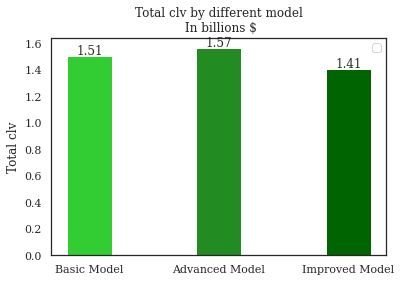

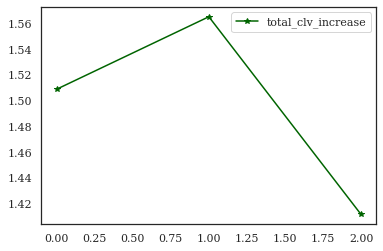

In [ ]:
# Overview of the total clv by the three different models
labels = ['Basic Model', 'Advanced Model', 'Improved Model']
total_clv = [(df_models['total_clv_basic'].sum())/1e9, (df_models['total_clv_advanced'].sum())/1e9, df_models['total_clv_improved'].sum()/1e9]
width = 0.35       # the width of the bars

fig, ax = plt.subplots()

ax.bar(labels, total_clv, width, color = ['limegreen' , 'forestgreen', 'darkgreen'])
add_value_label([1,2,3],total_clv)

ax.set_ylabel('Total clv')
ax.set_title('Total clv by different model' + "\n In billions $")
ax.legend()

df = pd.DataFrame(dict(total_clv_increase = total_clv))

df.plot(kind='line', marker='*', color='darkgreen')


plt.show();

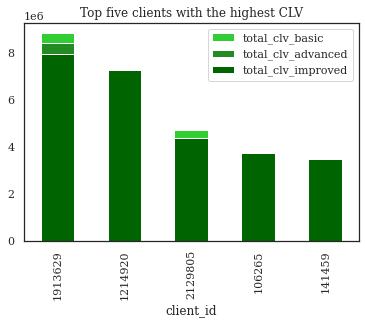

In [ ]:
# Top five client_ids with the highest CLV
# Client_ids for the best upside (here it is the basic model)
df_models.groupby("client_id")["total_clv_basic"].mean().sort_values(ascending=False)[:5].plot.bar(color = 'limegreen')
df_models.groupby("client_id")["total_clv_advanced"].mean().sort_values(ascending=False)[:5].plot.bar(color = 'forestgreen')
df_models.groupby("client_id")["total_clv_improved"].mean().sort_values(ascending=False)[:5].plot.bar(color = 'darkgreen')
plt.title("Top five clients with the highest CLV")
plt.legend();

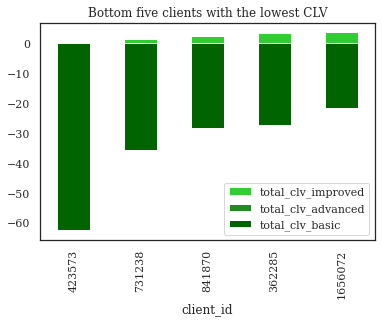

In [ ]:
# Bottom five client_ids with the highest CLV
# Client_ids for the words downsside (here it is the advanced model)
df_models.groupby("client_id")["total_clv_improved"].mean().sort_values(ascending=True)[:5].plot.bar(color = 'limegreen')
df_models.groupby("client_id")["total_clv_advanced"].mean().sort_values(ascending=True)[:5].plot.bar(color = 'forestgreen')
df_models.groupby("client_id")["total_clv_basic"].mean().sort_values(ascending=True)[:5].plot.bar(color = 'darkgreen')
plt.title("Bottom five clients with the lowest CLV")
plt.legend();

In [ ]:
### Now we are going to calculate the cumulative values for each model to plot it afterwise

In [ ]:
Cumulative = df_models.copy()
Cumulative.head()

,client_id,total_clv_basic,total_clv_advanced,total_clv_improved
0,6,479.103284,699.743369,595.276379
1,7,414.017852,502.821423,503.051995
2,14,304749.686434,322660.946403,252327.045782
3,18,24149.477495,21712.601810,19577.909663
4,37,914.626424,1241.297224,1181.842069


In [ ]:
Cumulative_basic = Cumulative['total_clv_basic'].sort_values().to_frame()
Cumulative_advanced = Cumulative['total_clv_advanced'].sort_values().to_frame()
Cumulative_improved = Cumulative['total_clv_improved'].sort_values().to_frame()
Cumulative_basic.head()

,total_clv_basic
27772,-62.431072
47802,-35.529510
55144,-28.271326
23783,-27.400392
108730,-21.526113


In [ ]:
Cumulative_basic["cumulative_basic"] = Cumulative_basic['total_clv_basic'].cumsum()
Cumulative_advanced["cumulative_advanced"] = Cumulative_advanced['total_clv_advanced'].cumsum()
Cumulative_improved["cumulative_improved"] = Cumulative_improved['total_clv_improved'].cumsum()

Cumulative_basic.head()

,total_clv_basic,cumulative_basic
27772,-62.431072,-62.431072
47802,-35.529510,-97.960583
55144,-28.271326,-126.231909
23783,-27.400392,-153.632301
108730,-21.526113,-175.158414


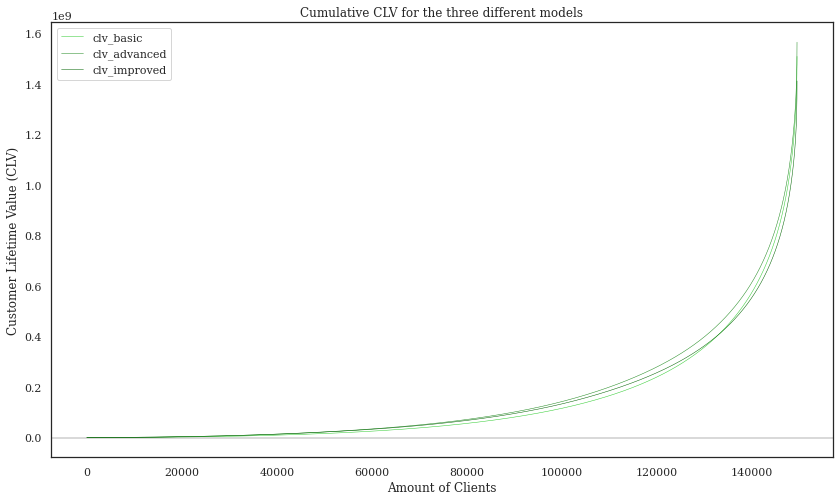

In [ ]:
# Cumulative CLV
plt_1 = plt.figure(figsize=(14, 8))

xpoints = np.arange(len(Cumulative_basic["cumulative_basic"]))
ypoints = np.array(Cumulative_basic["cumulative_basic"])

xpoints_1 = np.arange(len(Cumulative_basic["cumulative_basic"]))
ypoints_1 = np.array(Cumulative_advanced["cumulative_advanced"])

xpoints_2 = np.arange(len(Cumulative_basic["cumulative_basic"]))
ypoints_2 = np.array(Cumulative_improved["cumulative_improved"])

plt.plot(xpoints, ypoints, 'limegreen', linewidth = 0.5, label = "clv_basic")
plt.plot(xpoints_1, ypoints_1, 'forestgreen', linewidth = 0.5, label = "clv_advanced")
plt.plot(xpoints_2, ypoints_2, 'darkgreen', linewidth = 0.5, label = "clv_improved")

plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.3)
plt.ylabel("Customer Lifetime Value (CLV)")
plt.xlabel("Amount of Clients")

plt.legend()
plt.title("Cumulative CLV for the three different models")

plt.show()

# explain why we sort like this:
# another way to plot this is to use a histogram


In [ ]:
# On the previous graph we know because of the scales we can't really analyse the negative values therefore
# we zoom in on the previous graph to analyse negative values

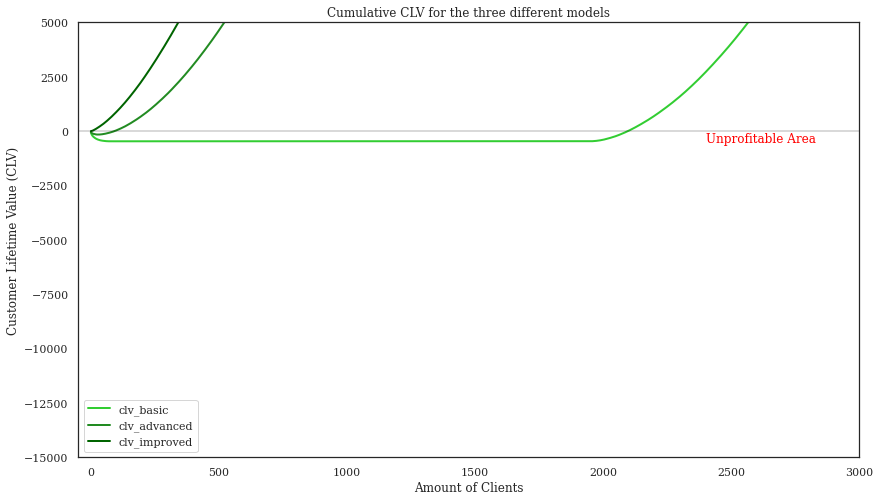

In [ ]:
plt_1 = plt.figure(figsize=(14, 8))

xpoints = np.arange(len(Cumulative_basic["cumulative_basic"]))
ypoints = np.array(Cumulative_basic["cumulative_basic"])

xpoints_1 = np.arange(len(Cumulative_basic["cumulative_basic"]))
ypoints_1 = np.array(Cumulative_advanced["cumulative_advanced"])

xpoints_2 = np.arange(len(Cumulative_basic["cumulative_basic"]))
ypoints_2 = np.array(Cumulative_improved["cumulative_improved"])

plt.plot(xpoints, ypoints, 'limegreen', linewidth = 2, label = "clv_basic")
plt.plot(xpoints_1, ypoints_1, 'forestgreen', linewidth = 2, label = "clv_advanced")
plt.plot(xpoints_2, ypoints_2, 'darkgreen', linewidth = 2, label = "clv_improved")

plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.3)
plt.ylabel("Customer Lifetime Value (CLV)")
plt.xlabel("Amount of Clients")

x_min = -50
x_max = 3000
y_min = -15000
y_max = 5000

plt.axis([x_min, x_max, y_min, y_max])

plt.legend()
plt.title("Cumulative CLV for the three different models")

plt.text(2400, -500,"Unprofitable Area", fontsize = 12, color = 'r')

plt.show()

In [ ]:
df_models.reset_index(inplace=True)

In [ ]:
clv_per_client = df_models[["client_id", "total_clv_improved"]]

In [ ]:
clv_per_client.isna().mean()

client_id             0.0
total_clv_improved    0.0
dtype: float64

In [ ]:
clv_per_client.to_csv("/content/drive/MyDrive/Capstone Project/04 Deliverables/04 Data/clv_per_client.csv")